# Dangerous Passes and Heatmmap Analysis with mplsoccer

This project analyses dangerous passes made by Spain using event data from football matches.

### What it does

1. Filters all successful passes by Spain.
2. Detects passes made within 15 seconds before a shot.
3. Displays their positions on a football pitch.
4. Builds a heatmap to show high-pressure passing zones.

#### In this case, we’ll identify which areas of the pitch have been the most dangerous in terms of passes — that is, those leading to clear goal-scoring opportunities — made by a team throughout a tournament or a series of matches. 

#### Here, we’ll use the example of the Spanish national team in the last European Championship.

### Import the necessary libraries

In [9]:
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.1 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
from mplsoccer import Pitch, Sbopen, VerticalPitch
import matplotlib.pyplot as plt
from statsbombpy import sb

##### We’ll add the competition ID as well as the season ID. It’s also important to include the team name exactly as it appears in the StatsBomb files:

### Data processing and analysis

In [16]:
#call statsbombpy API to get all free competitions
free_comps = sb.competitions()

# List of free competitions
free_comps.head()
latest_competitions = free_comps.loc[free_comps['season_name'] == '2025']
latest_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
71,53,315,Europe,UEFA Women's Euro,female,False,True,2025,2025-07-28T14:19:20.467348,2025-07-29T16:03:07.355174,2025-07-29T16:03:07.355174,2025-07-28T14:19:20.467348


In [29]:
# Open the data tournament that we look for
parser = Sbopen()
df_match = parser.match(competition_id=53, season_id=315)

In [30]:
# this is the team that I want to look for
team = "Spain Women's"

match_ids = df_match.loc[(df_match['home_team_name'] == team) | 
            (df_match['away_team_name'] == team)]['match_id']
            .tolist()

no_games = len(match_ids)
match_ids

[4020846, 4020077, 4018356, 3998855, 3998847, 3998839]

##### Generates and clean the data so that the passing map appears. 
##### Notice the `mask_shot` parameter — it tells Python to only include passes that resulted in a shot by Spain, as that indicates the preceding pass was potentially dangerous

In [90]:
import pandas as pd

danger_passes = pd.DataFrame()

for match_id in match_ids:

    # Load the event data for the current match
    df_events = parser.event(match_id)[0]
    
    for period in [1, 2]:
        
        # Select only open-play passes (no stoppages)
        mask_pass = (
            (df_events["team_name"] == team) &
            (df_events["type_name"] == "Pass") &
            (df_events["outcome_name"].isnull()) &
            (df_events["period"] == period) &
            (df_events["sub_type_name"].isnull())
        )

        passes = df_events.loc[
            mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]
        ]

        # Select the shots by the same team and period
        mask_shot = (
            (df_events["team_name"] == team) &
            (df_events["type_name"] == "Shot") &
            (df_events["period"] == period)
        )
        
        shots = df_events.loc[mask_shot, ["minute", "second"]]

        # Convert minutes to total seconds
        shot_times = shots["minute"] * 60 + shots["second"]
        shot_window = 15  # seconds before the shot
        shot_start = shot_times - shot_window

        # Remove negative times (at the start of the match)
        shot_start = shot_start.apply(lambda i: i if i > 0 else (period - 1) * 45 * 60)

        # Convert pass times to total seconds
        pass_times = passes["minute"] * 60 + passes["second"]

        # Detect passes that happened within 15 seconds before a shot
        pass_to_shot = pass_times.apply(
            lambda x: ((shot_start < x) & (x < shot_times)).any()
        )

        # Keep only the dangerous passes (those leading to a shot)
        danger_passes_period = passes.loc[pass_to_shot]

        # Add them to the total DataFrame
        danger_passes = pd.concat(
            [danger_passes, danger_passes_period], ignore_index=True
        )


## Visualise the dangerous passing zones.

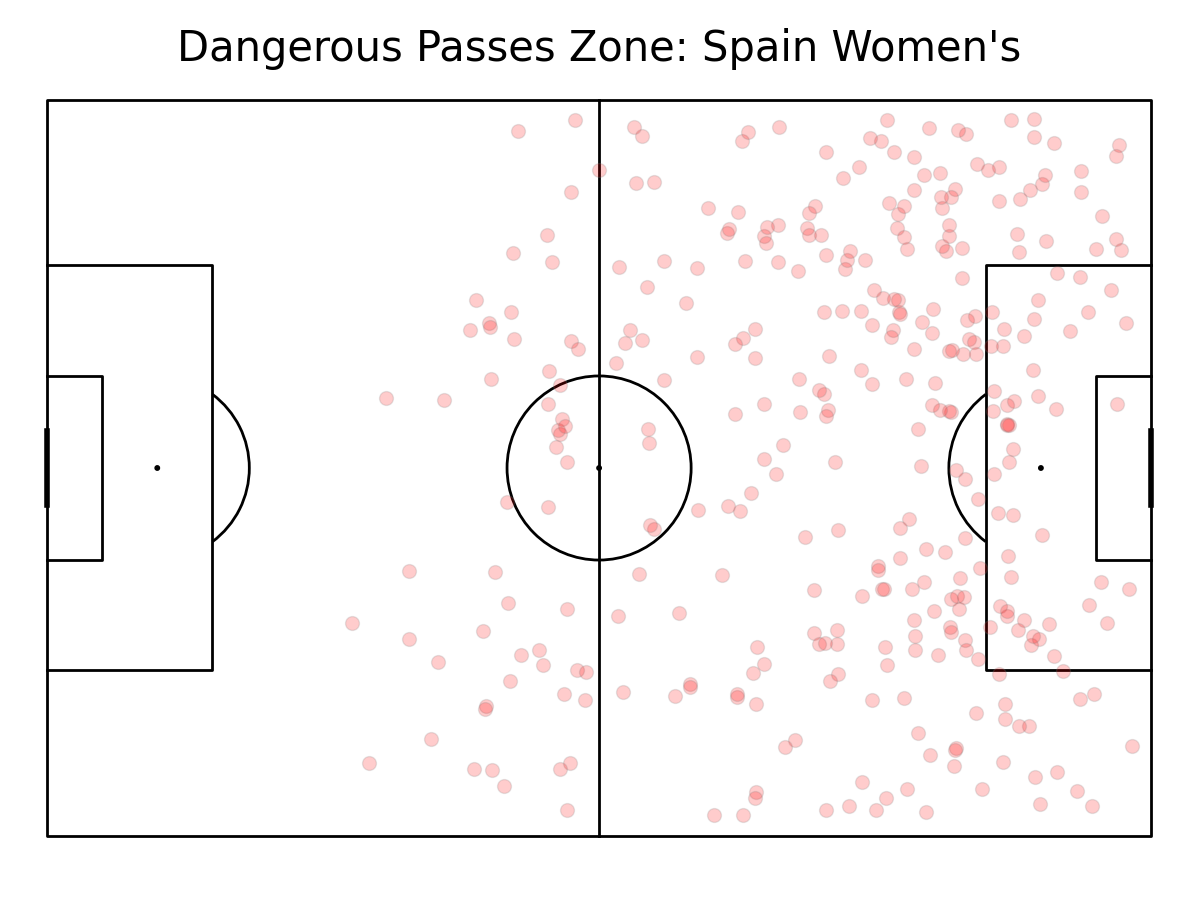

In [97]:
pitch = Pitch(line_color = 'black')
fig , ax = pitch.grid(grid_height=0.9,
                     title_height=.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

pitch.scatter(danger_passes.x, danger_passes.y, s=100,
             color='red',
             edgecolor='grey',
             linewidth=1,
             alpha=0.2,
             ax=ax['pitch'])

# lets add a title
fig.suptitle('Dangerous Passes Zone: ' + team, fontsize = 30)
plt.show()

## Now, let's display the dangerous passing zones by colour.

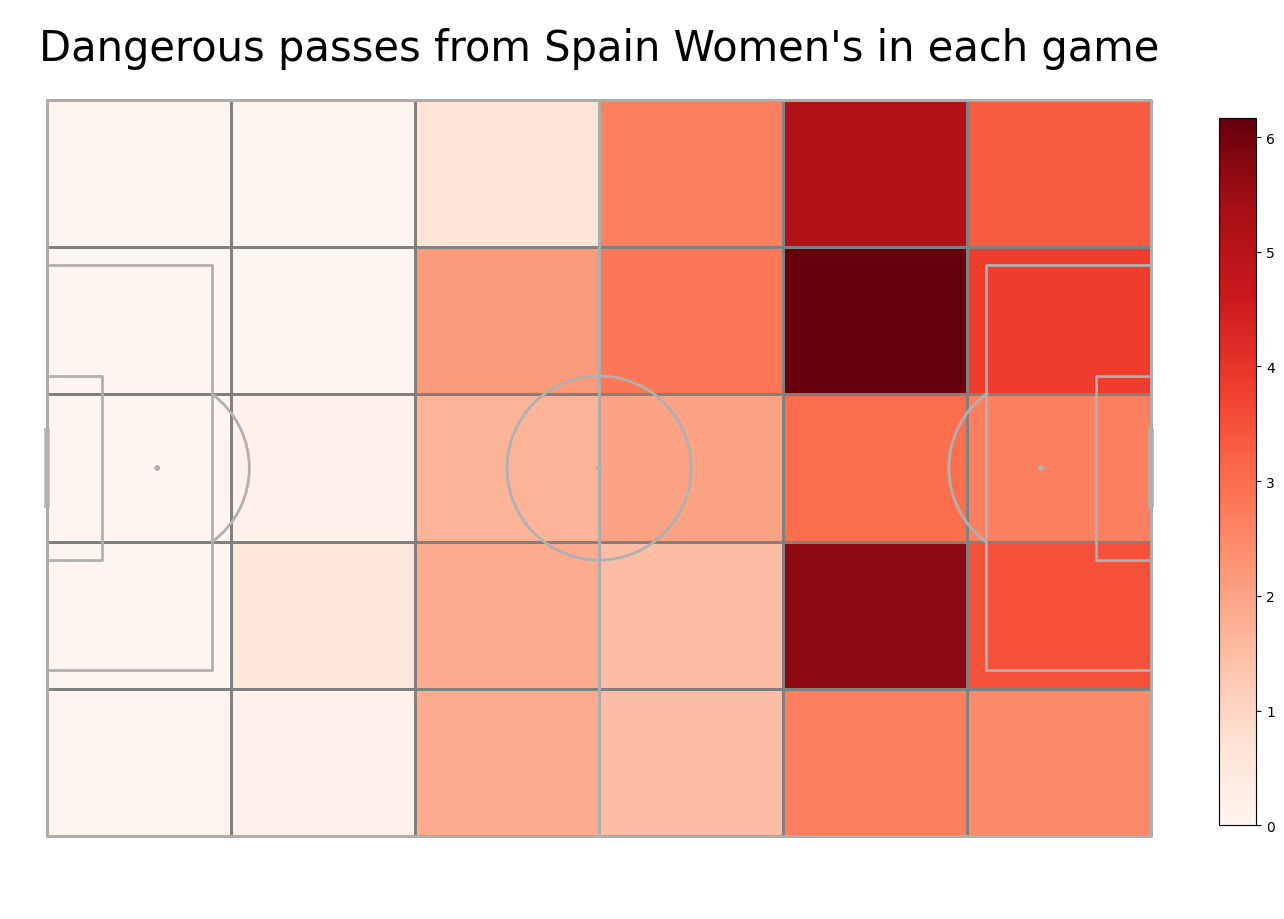

In [80]:
pitch = Pitch(line_zorder=2)
fig , ax = pitch.grid(grid_height=0.9,
                     title_height=.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count',
                                   bins=(6,5),
                                   normalize=False)

bin_statistic['statistic'] = bin_statistic['statistic']/no_games

#lets generate the colors for the map
pcm = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# legend
ax_cbar = fig.add_axes((1,0.093,0.03,0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Dangerous passes from " + team + " in each game" , fontsize=30)
plt.show()